In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from unicodedata import category
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets
#from ydata_profiling import ProfileReport
import seaborn as sns
import xgboost as xgb
#from category_encoders import TargetEncoder
from sklearn import datasets, linear_model, metrics, model_selection, svm
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict
from catboost import CatBoostClassifier
#from ydata_profiling.model.dataframe import preprocess

## Data overview

### Data load

In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


### Target distribution

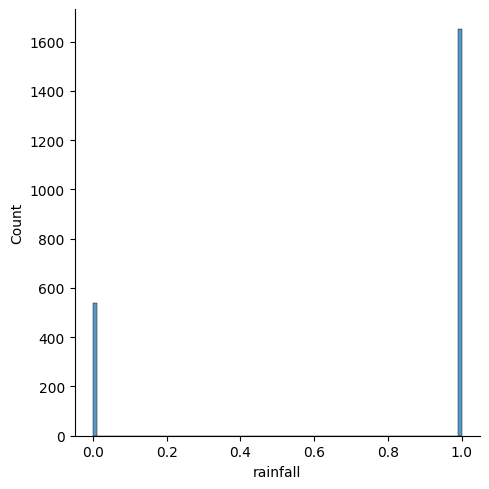

In [3]:
sns.displot(df['rainfall'])

### Features

#### Nan features

<Axes: >

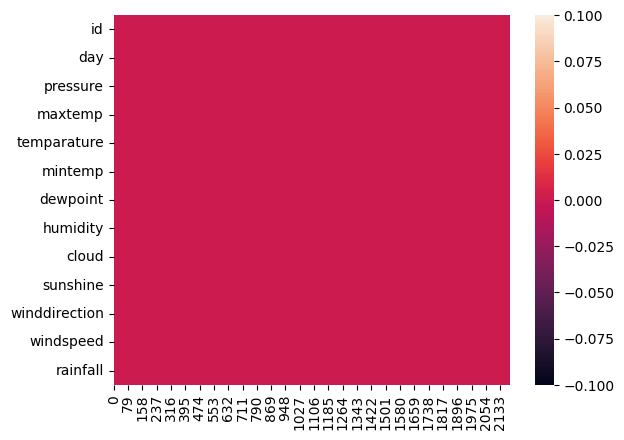

In [4]:
sns.heatmap(df.isna().transpose())

#### Num features

In [5]:
df_num_features = df.select_dtypes(include=['float64'])
df_num_features.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2
1,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9
2,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1
3,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6
4,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8


array([[<Axes: title={'center': 'pressure'}>,
        <Axes: title={'center': 'maxtemp'}>,
        <Axes: title={'center': 'temparature'}>],
       [<Axes: title={'center': 'mintemp'}>,
        <Axes: title={'center': 'dewpoint'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'cloud'}>,
        <Axes: title={'center': 'sunshine'}>,
        <Axes: title={'center': 'winddirection'}>],
       [<Axes: title={'center': 'windspeed'}>, <Axes: >, <Axes: >]],
      dtype=object)

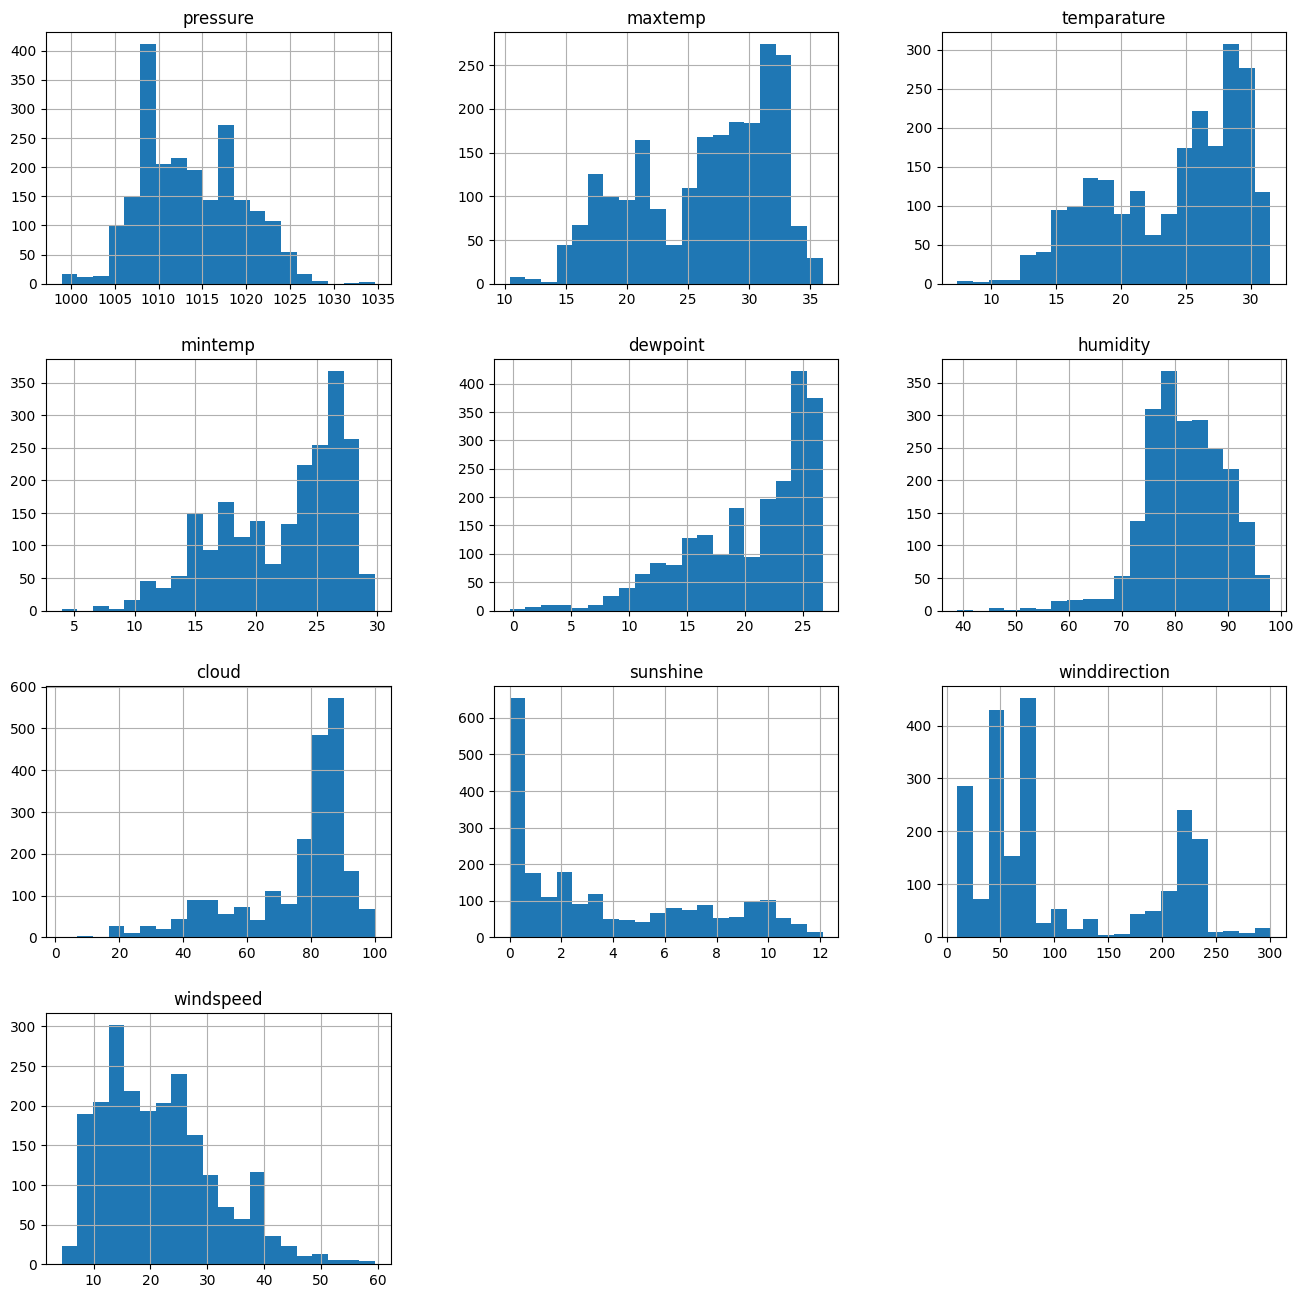

In [6]:
df_num_features.hist(figsize=(16, 16), bins=20)

### Correlations

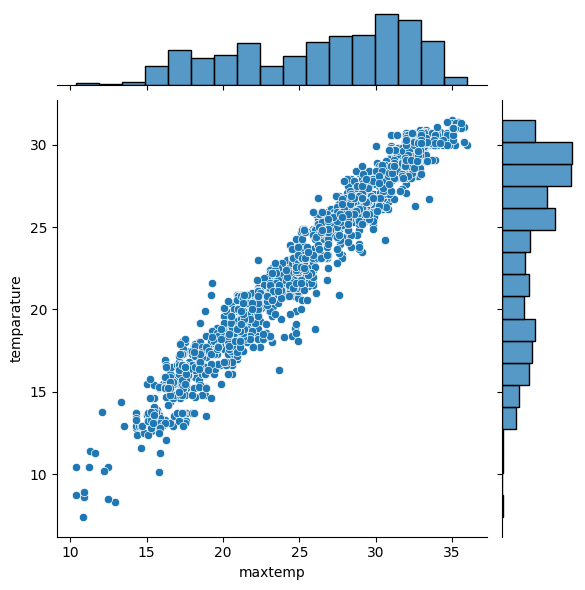

In [7]:
fig = sns.jointplot(df, x='maxtemp', y='temparature', kind='scatter')


<Axes: xlabel='cloud', ylabel='Density'>

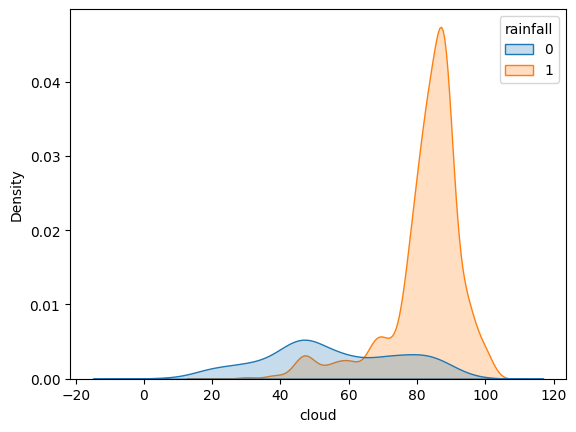

In [8]:
sns.kdeplot(data=df, x='cloud', hue='rainfall', fill=True)

### Outliers


<Axes: xlabel='pressure'>

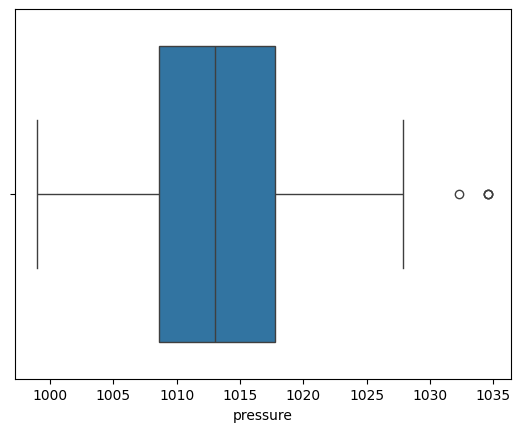

In [9]:
sns.boxplot(df, x='pressure')

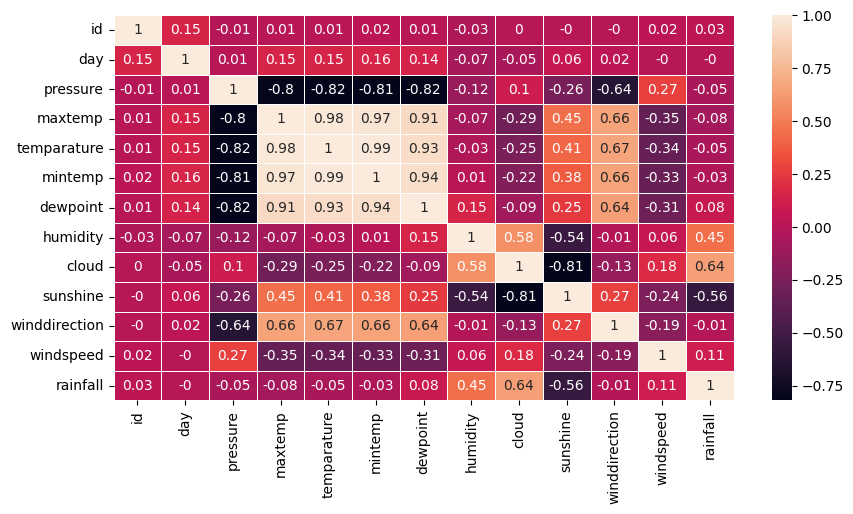

In [10]:
plt.figure(figsize=(10, 5))
matrix = sns.heatmap(np.round(df.corr(), 2), annot=True, linewidths=.5)


## Model Building

## Features

In [11]:
mean_val = df_test['winddirection'].mean()
df_test['winddirection'] = df_test['winddirection'].fillna(mean_val)

df_linear = df.copy()
df_linear_test = df_test.copy()
df_linear['windspeed'] = np.log(df['windspeed'])
df_linear_test['windspeed'] = np.log(df['windspeed'])
df_linear['temp_rate'] = df_linear['temparature'] -(df_linear['maxtemp'] - df_linear['mintemp']) / 2
df_linear_test['temp_rate'] = df_linear_test['temparature'] - (df_linear_test['maxtemp'] - df_linear_test['mintemp']) / 2
df_linear.drop(['mintemp'], axis=1, inplace=True)
df_linear.drop(['maxtemp'], axis=1, inplace=True)
df_linear.drop(['temparature'], axis=1, inplace=True)
df_linear_test.drop(['mintemp'], axis=1, inplace=True)
df_linear_test.drop(['maxtemp'], axis=1, inplace=True)
df_linear_test.drop(['temparature'], axis=1, inplace=True)
num_features = df_linear.select_dtypes(include=['float64']).columns
df_boost = df.copy()
df_boost_test = df_test.copy()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             730 non-null    int64  
 1   day            730 non-null    int64  
 2   pressure       730 non-null    float64
 3   maxtemp        730 non-null    float64
 4   temparature    730 non-null    float64
 5   mintemp        730 non-null    float64
 6   dewpoint       730 non-null    float64
 7   humidity       730 non-null    float64
 8   cloud          730 non-null    float64
 9   sunshine       730 non-null    float64
 10  winddirection  730 non-null    float64
 11  windspeed      730 non-null    float64
dtypes: float64(10), int64(2)
memory usage: 68.6 KB


#### Training sample creation

In [12]:
X_train = df_linear[num_features]
y_train = df_linear['rainfall']
X_test = df_linear_test[num_features]


In [13]:
def dropper(X):
    return X.drop(columns=['maxtemp'])

### Logistic Regression

In [14]:

preprocessor_logreg = ColumnTransformer([('scaler', StandardScaler(), num_features)])

In [15]:
pipeline_logreg = Pipeline([('preprocessor', preprocessor_logreg), ('classifier', LogisticRegression(max_iter=1000, penalty='l2'))])

In [16]:
pipeline_logreg.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [17]:
print(cross_val_score(pipeline_logreg, X_train, y_train, cv=5, scoring='roc_auc').mean())

0.8958136924803591


### CatBoost

In [18]:

X_train = df_boost.iloc[:, 1:-1]

y_train = df_boost['rainfall']
X_test = df_boost_test.iloc[:, 1:]
X_train.head()


,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8


In [23]:
from sklearn.ensemble import RandomForestClassifier
pipeline_boost = Pipeline([('classifier', CatBoostClassifier(depth=4, iterations=1000, verbose=0))])


In [24]:
pipeline_boost.fit(X_train, y_train)

,steps,"[('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False


In [21]:
print(cross_val_score(pipeline_boost, X_train, y_train, cv=5, scoring='roc_auc').mean())

0.891060606060606


## Submission

In [22]:
X_test = df_linear_test[num_features]
df_submission = pd.read_csv('sample_submission.csv', index_col=False)
df_submission['rainfall'] = pipeline_logreg.predict_proba(X_test)[:, 1]
df_submission.columns = ['id', 'rainfall']
df_submission.to_csv('submission.csv', index=False)